In [1]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
DATASET = "classification_dataset"

# CLASSES = ["dirty", "good"]
CLASSES = ["dirty", "clean", "suspected"]
SUBSETS = ["train", "val"]

MAX_COUNT = {
    "train": {
        # "clean": 90, 
    },
    "val": {
        # "clean": 25, 
    }
}

# EDA

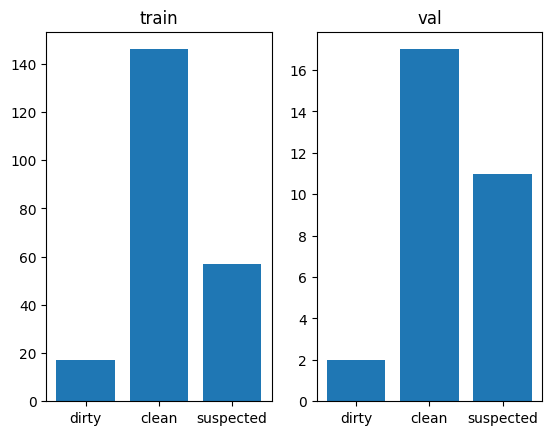

In [3]:
fig, axes = plt.subplots(ncols=2)

img_paths = {subset : {} for subset in SUBSETS}
for subset in SUBSETS:
    for cls in CLASSES:
        max_count = MAX_COUNT[subset].get(cls)
        img_paths[subset][cls] = glob(f"{DATASET}/{subset}/{cls}/*")
        if max_count is not None:
            img_paths[subset][cls] = img_paths[subset][cls][:max_count]


for ax, subset in zip(axes, SUBSETS):
    stats = {cls: len(img_paths[subset][cls]) for cls in CLASSES}
    ax.set_title(subset)

    ax.bar(stats.keys(), stats.values())

plt.show()

# LogReg

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
targets = {subset: [] for subset in SUBSETS}
features = {subset: [] for subset in SUBSETS}

for subset in SUBSETS:
    for cls in CLASSES:
        for img_path in img_paths[subset][cls]:
            img = cv2.imread(img_path)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blur = np.mean((gray - cv2.GaussianBlur(gray, (7, 7), 0)) ** 2)

            glcm = graycomatrix(gray, distances=[1], angles=[0])
            contrast = graycoprops(glcm, "contrast")[0, 0]
            homogeneity = graycoprops(glcm, "homogeneity")[0, 0]

            features[subset].append(np.array([blur, homogeneity, contrast]))
            targets[subset].append(int(cls == "dirty"))
    
    features[subset] = np.vstack(features[subset])
    targets[subset] = np.array(targets[subset])

In [6]:
logreg = LogisticRegression()
logreg.fit(features["train"], targets["train"])

for subset in SUBSETS:
    print(f"\n ------ {subset} ----------")
    y_pred = logreg.predict(features[subset])
    accuracy = accuracy_score(targets[subset], y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    print("Classification Report:")
    print(classification_report(targets[subset], y_pred))


 ------ train ----------
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       203
           1       0.58      0.41      0.48        17

    accuracy                           0.93       220
   macro avg       0.77      0.69      0.72       220
weighted avg       0.92      0.93      0.93       220


 ------ val ----------
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.50      0.50      0.50         2

    accuracy                           0.93        30
   macro avg       0.73      0.73      0.73        30
weighted avg       0.93      0.93      0.93        30



# YOLO

In [7]:
from ultralytics import YOLO

In [8]:
model = YOLO("yolo11n-cls.pt") 
imgsize = 640
epochs = 30

100%|██████████| 5.52M/5.52M [00:00<00:00, 16.1MB/s]


## Train

In [9]:
results = model.train(
    data="classification_dataset", 
    epochs=epochs, 
    imgsz=imgsize,
)

Ultralytics 8.3.47  Python-3.12.3 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti Laptop GPU, 16384MiB)
engine\trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=classification_dataset, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

100%|██████████| 5.35M/5.35M [00:00<00:00, 16.1MB/s]


AMP: checks passed 


train: Scanning C:\repos\notrcnickel_hack_2024\research\train_classification\classification_dataset\train... 220 images, 0 corrupt: 100%|██████████| 220/220 [00:00<00:00, 2901.56it/s]

train: New cache created: C:\repos\notrcnickel_hack_2024\research\train_classification\classification_dataset\train.cache



val: Scanning C:\repos\notrcnickel_hack_2024\research\train_classification\classification_dataset\val... 30 images, 0 corrupt: 100%|██████████| 30/30 [00:00<00:00, 2753.49it/s]

val: New cache created: C:\repos\notrcnickel_hack_2024\research\train_classification\classification_dataset\val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\classify\train
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

                   all        0.6          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 19.84it/s]

                   all      0.733          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 19.48it/s]

                   all      0.733          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 20.42it/s]

                   all      0.867          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]

                   all      0.867          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 19.75it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 18.63it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 20.55it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


      10/30      1.72G     0.1514         12        640: 100%|██████████| 14/14 [00:01<00:00, 10.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 20.89it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


      11/30      1.71G     0.1123         12        640: 100%|██████████| 14/14 [00:01<00:00,  9.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


      12/30      1.72G     0.1048         12        640: 100%|██████████| 14/14 [00:01<00:00, 13.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 18.52it/s]

                   all      0.933          1



      Epoch    GPU_mem       loss  Instances       Size


      13/30      1.71G    0.08397         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 19.52it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


      14/30      1.72G    0.07883         12        640: 100%|██████████| 14/14 [00:01<00:00,  9.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 21.79it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      15/30      1.71G    0.07751         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


      16/30      1.72G    0.06625         12        640: 100%|██████████| 14/14 [00:01<00:00, 13.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 20.31it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


      17/30      1.71G    0.09336         12        640: 100%|██████████| 14/14 [00:01<00:00,  9.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 18.46it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      18/30      1.72G    0.08633         12        640: 100%|██████████| 14/14 [00:01<00:00,  9.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 20.66it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      19/30      1.71G     0.1118         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 16.69it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      20/30      1.72G    0.05203         12        640: 100%|██████████| 14/14 [00:01<00:00, 11.06it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 17.02it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      21/30      1.88G     0.1148         12        640: 100%|██████████| 14/14 [00:07<00:00,  1.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 20.28it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      22/30      1.72G    0.05006         12        640: 100%|██████████| 14/14 [00:01<00:00,  9.21it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 21.03it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


      23/30      1.71G    0.04143         12        640: 100%|██████████| 14/14 [00:01<00:00, 10.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 18.08it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


      24/30      1.72G    0.03817         12        640: 100%|██████████| 14/14 [00:01<00:00, 11.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 20.23it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      25/30      1.71G    0.01715         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 22.10it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      26/30      1.72G     0.0319         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 23.56it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      27/30      1.71G    0.02675         12        640: 100%|██████████| 14/14 [00:01<00:00,  9.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 17.70it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      28/30      1.72G    0.03382         12        640: 100%|██████████| 14/14 [00:01<00:00, 12.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 21.61it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      29/30      1.71G    0.02488         12        640: 100%|██████████| 14/14 [00:01<00:00,  9.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 19.71it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      30/30      1.72G    0.03883         12        640: 100%|██████████| 14/14 [00:01<00:00,  9.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 19.42it/s]

                   all          1          1



30 epochs completed in 0.022 hours.
Optimizer stripped from runs\classify\train\weights\last.pt, 3.2MB
Optimizer stripped from runs\classify\train\weights\best.pt, 3.2MB

Validating runs\classify\train\weights\best.pt...
Ultralytics 8.3.47  Python-3.12.3 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3080 Ti Laptop GPU, 16384MiB)
YOLO11n-cls summary (fused): 112 layers, 1,529,867 parameters, 0 gradients, 3.2 GFLOPs
train: C:\repos\notrcnickel_hack_2024\research\train_classification\classification_dataset\train... found 220 images in 3 classes  
val: C:\repos\notrcnickel_hack_2024\research\train_classification\classification_dataset\val... found 30 images in 3 classes  
test: None...


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


                   all          1          1
Speed: 0.7ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train


## Inference

In [11]:
model = YOLO("good_run/weights/best.pt")

img_path = "classification_dataset/val/dirty/F2_1_1_2.ts_f_500.jpg"

img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = model.predict(img, imgsz=imgsize, verbose=False)[0]

probs = result.probs.data.cpu().numpy()
print(result.names[probs.argmax()])

dirty
